In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from random import shuffle
import torch
from torch import nn
import math
from glob import glob
import sys
import shutil  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


%matplotlib inline

In [ ]:
!pip install --upgrade --no-cache-dir gdown
import gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
#https://drive.google.com/drive/u/1/folders/1aw9AmGTb6Iw2gcIqwCJyDDInungGxg_j
#https://drive.google.com/drive/u/1/folders/1Iye3lkPex9kAnuWinr9NLmj51vAl5t5A

In [ ]:
# Download training data
url = "https://drive.google.com/drive/folders/16ZaNLVBZgn7RYFLiF1jt-WcCF1aRb8aP"
gdown.download_folder(url, quiet=True, use_cookies=False, remaining_ok=True)

['/content/Martian Inverted Channels/Aeolis Dorsa/images/ESP_020673_1750_RED.browse.jpg',
 '/content/Martian Inverted Channels/Aeolis Dorsa/images/ESP_031064_1760_RED.browse.jpg',
 '/content/Martian Inverted Channels/Aeolis Dorsa/images/ESP_035600_1765_RED.browse.jpg',
 '/content/Martian Inverted Channels/Aeolis Dorsa/images/ESP_039385_1760_RED.browse.jpg',
 '/content/Martian Inverted Channels/Aeolis Dorsa/images/ESP_048233_1770_RED.browse.jpg',
 '/content/Martian Inverted Channels/Aeolis Dorsa/images/ESP_053639_1760_RED.browse.jpg',
 '/content/Martian Inverted Channels/Aeolis Dorsa/images/ESP_055195_1735_RED.browse.jpg',
 '/content/Martian Inverted Channels/Aeolis Dorsa/images/ESP_071971_1760_RED.browse.jpg',
 '/content/Martian Inverted Channels/Aeolis Dorsa/images/ESP_072327_1750_RED.browse.jpg',
 '/content/Martian Inverted Channels/Aeolis Dorsa/images/PSP_009623_1755_RED.browse.jpg',
 '/content/Martian Inverted Channels/Aeolis Dorsa/images/PSP_010533_1755_RED.browse.jpg',
 '/content

In [ ]:
# Download test data
url = "https://drive.google.com/drive/folders/1dGwTm47UJSp0_qLl0n0VCUPMCu56xEZD"
gdown.download_folder(url, quiet=True, use_cookies=False, remaining_ok=True)

['/content/Test data/Aeolis Dorsa/images/ESP_072116_1740_RED.browse.jpg',
 '/content/Test data/Aeolis Dorsa/masks/ESP_072116_1740_RED.browse.png',
 '/content/Test data/Miyamoto Crater/images/ESP_016631_1770_RED.browse.jpg',
 '/content/Test data/Miyamoto Crater/images/ESP_074759_1855_RED.browse.jpg',
 '/content/Test data/Miyamoto Crater/masks/ESP_016631_1770_RED.browse.png',
 '/content/Test data/Miyamoto Crater/masks/ESP_074759_1855_RED.browse.png']

In [ ]:
dirname = './Martian Inverted Channels/'
# folders = ["Autocontrast","Brightness","Hflip", "Sharpness", "Vflip"]
folders = ["Hflip", "Vflip", "GaussianBlur", "ImagePatchesAboveThreshold", "ImagePatchesBelowThreshold"]

for fold in folders:
  if not os.path.exists(dirname+fold+'/images'):
    os.makedirs(dirname+fold+'/images')
  if not os.path.exists(dirname+fold+'/masks'):
    os.makedirs(dirname+fold+'/masks')

imageNames = sorted(glob('./Martian Inverted Channels' + '/*/images/*.jpg'))

# plot image

In [ ]:
testImages = sorted(glob('./Test data' + '/*/images/*.jpg'))
if not os.path.exists('./TestingData'):
  os.makedirs('./TestingData')
if not os.path.exists('./TestingData/TestingPatches'):
  os.makedirs('./TestingData/TestingPatches')
if not os.path.exists('./TestingData/TestingPatches/images'):
  os.makedirs('./TestingData/TestingPatches/images')
if not os.path.exists('./TestingData/TestingPatches/masks'):
  os.makedirs('./TestingData/TestingPatches/masks')

In [ ]:
patchSize = 256

# Five crop

In [ ]:
import torchvision.transforms as transforms
import torchvision
import PIL

# imageNames = sorted(glob('./Martian Inverted Channels' + '/*/images/*.jpg'))


patchHeight = patchSize
patchWidth = patchSize
patchList = []
dirName = './TestingData/TestingPatches/'

# image1 = image[0:512,0:512]
# image2 = image[512:1024,0:512]
# image3 = image[1024:1536,0:512]
testImageSizes = []
for testImagePath in testImages:
  image = cv2.imread(testImagePath)
  
  mask_path = testImagePath.replace('images', 'masks').replace('.jpg', '.png')
  mask = cv2.imread(mask_path)

  image_array = np.array(image)
  imageSize = image_array.shape
  imageHeight = imageSize[0]
  imageWidth = imageSize[1]

  testImageSizes.append([testImagePath[len(testImagePath)-30:-4],[imageWidth,imageHeight]])

  for y in range (0,imageHeight,patchSize):
    for x in range (0,imageWidth,patchSize):
      if ((y+patchHeight > imageHeight) and (x+patchWidth > imageWidth)):
        pat = image [y:imageHeight,x:imageWidth]
        patch = np.pad(pat,((0,y+patchHeight-imageHeight),(0,x+patchWidth-imageWidth),(0,0)),'reflect')
        maskPatch = mask [y:imageHeight,x:imageWidth]
        maskPatch = np.pad(maskPatch,((0,y+patchHeight-imageHeight),(0,x+patchWidth-imageWidth),(0,0)),'reflect')
      elif ((y+patchHeight <= imageHeight) and (x+patchWidth > imageWidth)):
        pat = image [y:y+patchHeight,x:imageWidth]
        patch = np.pad(pat,((0,0),(0,x+patchWidth-imageWidth),(0,0)),'reflect') 
        maskPatch = mask [y:y+patchHeight,x:imageWidth]
        maskPatch = np.pad(maskPatch,((0,0),(0,x+patchWidth-imageWidth),(0,0)),'reflect') 
      elif ((y+patchHeight > imageHeight) and (x+patchWidth <= imageWidth)):
        pat = image [y:imageHeight,x:x+patchWidth]
        patch = np.pad(pat,((0,y+patchHeight-imageHeight),(0,0),(0,0)),'reflect')
        maskPatch = mask [y:imageHeight,x:x+patchWidth]
        maskPatch = np.pad(maskPatch,((0,y+patchHeight-imageHeight),(0,0),(0,0)),'reflect')
      else:
        patch = image [y:y+patchHeight,x:x+patchWidth]
        maskPatch = mask [y:y+patchHeight,x:x+patchWidth]

      patchName = testImagePath[len(testImagePath)-30:-4]+"_"+str(int(y/patchSize))+"_"+str(int(x/patchSize))
      # print(patchName)
        # plt.imshow(patch)
        # plt.show()
        # plt.axis('off')
        # plt.imshow(maskPatch)
        # plt.show()
      cv2.imwrite('./TestingData/TestingPatches/images/'+patchName+'.jpg', patch)
      cv2.imwrite('./TestingData/TestingPatches/masks/'+patchName+'.png', maskPatch)
      patchList.append(patch)


# for patch in patchList:
#   plt.imshow(patch)
#   plt.show()
# image = transforms.functional.to_pil_image(image)

# image4 = torch.cat((torch.from_numpy(image1),torch.from_numpy(image2)), 0)

# image4 = torch.cat((image4,torch.from_numpy(image3)), 0)
# plt.figure(figsize=(15,15))
# plt.subplot(1,5,1)
# plt.imshow(patchList[-1])
# cv2.imwrite(dirName+"images/"+"ESP_072116_1740_RED.browse_11"+'.jpg', patchList[-1])






In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
import torchvision.transforms as transforms
import PIL
import random
from scipy import ndimage


class segDataset(torch.utils.data.Dataset):
    def __init__(self, root, training, transform=None):
        super(segDataset, self).__init__()
        self.root = root
        self.training = training
        self.transform = transform
        self.IMG_NAMES = sorted(glob(self.root + '/images/*.jpg'))
        self.BGR_classes = {'Background' : [ 0, 0, 0],
                            'Inverted Channel' : [ 0, 0, 255]} # in BGR

        self.bin_classes = ['Background', 'Inverted Channel']


    def __getitem__(self, idx):
        
        img_path = self.IMG_NAMES[idx]
        mask_path = img_path.replace('images', 'masks').replace('.jpg', '.png')

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path)
        # plt.imshow(mask)
        cls_mask = np.zeros(mask.shape)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        cls_mask[mask == self.BGR_classes['Background']] = self.bin_classes.index('Background')
        cls_mask[mask == self.BGR_classes['Inverted Channel']] = self.bin_classes.index('Inverted Channel')
        torch.set_printoptions(profile="full")
        #print("class mask",cls_mask)
        cls_mask = cls_mask[:,:,2] #removing nearby elements [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] -> [0,2,4,6,8]
        #print("---------------------------------------------------")
        #print(cls_mask)
        if self.training==True:
            if self.transform:
              image = transforms.functional.to_pil_image(image)
              image = self.transform(image)
              image = np.array(image)

            # 90 degree rotation
            if np.random.rand()<0.5:
              angle = np.random.randint(4) * 90
              image = ndimage.rotate(image,angle,reshape=True)
              cls_mask = ndimage.rotate(cls_mask,angle,reshape=True)

        # image = cv2.resize(image, (512,512))/255.0
        # cls_mask = cv2.resize(cls_mask, (512,512))
        image = cv2.resize(image, (patchSize,patchSize))/255.0
        cls_mask = cv2.resize(cls_mask, (patchSize,patchSize)) 
        # image = np.moveaxis(image, -1, 0)
        img = [image]
        img = np.array(img)
        return torch.tensor(img).float(), torch.tensor(cls_mask, dtype=torch.int64), img_path


    def __len__(self):
        return len(self.IMG_NAMES)

In [ ]:
# plt.figure(figsize=(15,15))
# plt.subplot(1,5,1)
# plt.imshow(image)
# plt.subplot(1,5,2)
# plt.imshow(image1)
# plt.subplot(1,5,3)
# plt.imshow(image2)
# plt.subplot(1,5,4)
# plt.imshow(image3)
# plt.subplot(1,5,5)
# plt.imshow(image4)
testDataset = segDataset('./TestingData', training = False)
print(testDataset.IMG_NAMES)

[]


# Patch Learning

In [ ]:
import math
import torchvision.transforms as transforms
import torchvision
import PIL

dirname = './Martian Inverted Channels/'


for imagePath in imageNames:
  image = cv2.imread(imagePath)
  image = transforms.functional.to_pil_image(image)
  image_array = np.array(image)

  imageSize = image_array.shape
  imageHeight = imageSize[0]
  imageWidth = imageSize[1]
  # print(imageSize)

  mask_path = imagePath.replace('images', 'masks').replace('.jpg', '.png')
  mask = cv2.imread(mask_path)
  mask = transforms.functional.to_pil_image(mask)
#   cv2.imwrite(dirname+folders[0]+"/masks/"+imgName+'.png', mask)

  strideL = ((math.ceil(imageWidth/patchSize))*patchSize - imageWidth)/(math.floor(imageWidth/patchSize))
  # print(strideL)
  strideL = int(strideL)+1

  strideT = ((math.ceil(imageHeight/patchSize))*patchSize - imageHeight)/(math.floor(imageHeight/patchSize))
  # print(strideT)
  strideT = int(strideT)+1
  count =0
  for left in range(0,imageWidth,patchSize-strideL):
    # print("left ", left)
    if(left+patchSize<imageWidth):
      for top in range(0,imageHeight,patchSize-strideT):  
        if(top+patchSize<imageHeight):
          #print(left,top)
          imgName = imagePath[len(imagePath)-30:-4]+"-"+str(top)+"-"+str(left) 
          croppedImage = transforms.functional.crop(image,top,left,patchSize,patchSize)
          croppedImage = np.array(croppedImage)

          croppedMask = transforms.functional.crop(mask,top,left,patchSize,patchSize)
          croppedMask = np.array(croppedMask)
          count = np.count_nonzero(croppedMask)
          if(count>600000):
            cv2.imwrite(dirname+folders[3]+"/images/"+imgName+'.jpg', croppedImage)
            cv2.imwrite(dirname+folders[3]+"/masks/"+imgName+'.png', croppedMask)
          else:
            cv2.imwrite(dirname+folders[4]+"/images/"+imgName+'.jpg', croppedImage)
            cv2.imwrite(dirname+folders[4]+"/masks/"+imgName+'.png', croppedMask)
          
            # if(imagePath=='./Martian Inverted Channels/Aeolis Dorsa/images/PSP_010533_1755_RED.browse.jpg'):
              # plt.axis('off')
              # plt.imshow(croppedImage)
              # plt.show()
              # plt.axis('off')
              # plt.imshow(croppedMask)
              # plt.show()

  print("patching ",imagePath)



patching  ./Martian Inverted Channels/Aeolis Dorsa/images/ESP_020673_1750_RED.browse.jpg
patching  ./Martian Inverted Channels/Aeolis Dorsa/images/ESP_031064_1760_RED.browse.jpg
patching  ./Martian Inverted Channels/Aeolis Dorsa/images/ESP_035600_1765_RED.browse.jpg
patching  ./Martian Inverted Channels/Aeolis Dorsa/images/ESP_039385_1760_RED.browse.jpg
patching  ./Martian Inverted Channels/Aeolis Dorsa/images/ESP_048233_1770_RED.browse.jpg
patching  ./Martian Inverted Channels/Aeolis Dorsa/images/ESP_053639_1760_RED.browse.jpg
patching  ./Martian Inverted Channels/Aeolis Dorsa/images/ESP_055195_1735_RED.browse.jpg
patching  ./Martian Inverted Channels/Aeolis Dorsa/images/ESP_071971_1760_RED.browse.jpg
patching  ./Martian Inverted Channels/Aeolis Dorsa/images/ESP_072327_1750_RED.browse.jpg
patching  ./Martian Inverted Channels/Aeolis Dorsa/images/PSP_009623_1755_RED.browse.jpg
patching  ./Martian Inverted Channels/Aeolis Dorsa/images/PSP_010533_1755_RED.browse.jpg
patching  ./Martian I

In [ ]:
# import math
# import torchvision.transforms as transforms
# import torchvision
# import PIL

# testImages = sorted(glob('./Test data' + '/*/images/*.jpg'))
# if not os.path.exists('./TestingData'):
#   os.makedirs('./TestingData')
# if not os.path.exists('./TestingData/TestingPatches'):
#   os.makedirs('./TestingData/TestingPatches')
# if not os.path.exists('./TestingData/TestingPatches/images'):
#     os.makedirs('./TestingData/TestingPatches/images')
# if not os.path.exists('./TestingData/TestingPatches/masks'):
#     os.makedirs('./TestingData/TestingPatches/masks')

# for imagePath in testImages:
#   image = cv2.imread(imagePath)
#   image = transforms.functional.to_pil_image(image)
#   image_array = np.array(image)
#   imageSize = image_array.shape
#   imageHeight = imageSize[0]
#   imageWidth = imageSize[1]
#   print(imageSize)

#   mask_path = imagePath.replace('images', 'masks').replace('.jpg', '.png')
#   mask = cv2.imread(mask_path)
#   mask = transforms.functional.to_pil_image(mask)
# #   cv2.imwrite(dirname+folders[0]+"/masks/"+imgName+'.png', mask)

#   strideL = ((math.ceil(imageWidth/512))*512 - imageWidth)/(math.floor(imageWidth/512))
#   # print(strideL)
#   strideL = int(strideL)+1

#   strideT = ((math.ceil(imageHeight/512))*512 - imageHeight)/(math.floor(imageHeight/512))
#   # print(strideT)
#   strideT = int(strideT)+1

#   for left in range(0,imageWidth,512-strideL):
#     # print("left ", left)
#     if(left+512<imageWidth):
#       for top in range(0,imageHeight,512-strideT):  
#         if(top+512<imageHeight):
#           #print(left,top)
#           imgName = imagePath[len(imagePath)-30:-4]+"-"+str(top)+"-"+str(left) 
#           croppedImage = transforms.functional.crop(image,top,left,512,512)
#           croppedImage = np.array(croppedImage)
          
#           croppedMask = transforms.functional.crop(mask,top,left,512,512)
#           croppedMask = np.array(croppedMask)
#           count = np.count_nonzero(croppedMask)
#           if(count>2600):
#             cv2.imwrite('./TestingData/TestingPatches'+"/images/"+imgName+'.jpg', croppedImage)
#             cv2.imwrite('./TestingData/TestingPatches'+"/masks/"+imgName+'.png', croppedMask)

#   print("patching test ",imagePath)



(2412, 1703, 3)
patching test  ./Test data/Aeolis Dorsa/images/ESP_072116_1740_RED.browse.jpg


In [ ]:
dirname = './Patch Learning/'
# folders = ["Autocontrast","Brightness","Hflip", "Sharpness", "Vflip"]
folders = ["Hflip", "Vflip", "GaussianBlur", "ImagePatchesAboveThreshold", "ImagePatchesBelowThreshold","HVflip"]
if not os.path.exists('./Patch Learning'):
  os.makedirs('./Patch Learning')
if not os.path.exists('./Patch Learning/ImagePatchesAboveThreshold'):
  os.makedirs('./Patch Learning/ImagePatchesAboveThreshold')
if not os.path.exists('./Patch Learning/ImagePatchesBelowThreshold'):
  os.makedirs('./Patch Learning/ImagePatchesBelowThreshold')
if not os.path.exists('./Patch Learning/Hflip'):
  os.makedirs('./Patch Learning/Hflip')
if not os.path.exists('./Patch Learning/Vflip'):
  os.makedirs('./Patch Learning/Vflip')
if not os.path.exists('./Patch Learning/HVflip'):
  os.makedirs('./Patch Learning/HVflip')
if not os.path.exists('./Patch Learning/GaussianBlur'):
  os.makedirs('./Patch Learning/GaussianBlur')

for fold in folders:
  if not os.path.exists(dirname+fold+'/images'):
    os.makedirs(dirname+fold+'/images')
  if not os.path.exists(dirname+fold+'/masks'):
    os.makedirs(dirname+fold+'/masks')


In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
import torchvision.transforms as transforms
import torchvision
import PIL
import random
from scipy import ndimage

count_channels = 0
count_background = 0

directory = './Patch Learning/'
imageNames = sorted(glob('./Martian Inverted Channels' + '/ImagePatchesAboveThreshold/images/*.jpg'))
imageNamesBelow = sorted(glob('./Martian Inverted Channels' + '/ImagePatchesBelowThreshold/images/*.jpg'))
# print(len(imageNames))
# imageNames = sorted(glob('./Martian Inverted Channels' + '/*/images/*.jpg'))
# image1 = cv2.imread(imageNames[0])
# cv2.imwrite("./sample_data/testss.jpg", image1)
# plt.imshow(image1)
# plt.show()
for imagePath in imageNames:
  # print(imagePath)
  count_channels +=1
  image = cv2.imread(imagePath)
  image = transforms.functional.to_pil_image(image)
  image = np.array(image)
  imgName = imagePath[61:-4]
  # print(imgName)
  cv2.imwrite(directory+folders[3]+"/images/"+imgName+'.jpg', image)

  mask_path = imagePath.replace('images', 'masks').replace('.jpg', '.png')
  mask = cv2.imread(mask_path)
  mask = transforms.functional.to_pil_image(mask)
  mask = np.array(mask)
  cv2.imwrite(directory+folders[3]+"/masks/"+imgName+'.png', mask)
print("-> Image Patch Saved above threshold....")

for imagePath in imageNamesBelow:
  count_background+=1
  image = cv2.imread(imagePath)
  image = transforms.functional.to_pil_image(image)
  image = np.array(image)
  imgName = imagePath[61:-4]
  cv2.imwrite(directory+folders[4]+"/images/"+imgName+'.jpg', image)

  mask_path = imagePath.replace('images', 'masks').replace('.jpg', '.png')
  mask = cv2.imread(mask_path)
  mask = transforms.functional.to_pil_image(mask)
  mask = np.array(mask)
  cv2.imwrite(directory+folders[4]+"/masks/"+imgName+'.png', mask)
print("-> Image Patch Saved below threshold....")


# #Adjusting Auto contrast
# for imagePath in imageNames:
#   image = cv2.imread(imagePath)
#   image = transforms.functional.to_pil_image(image)
#   #image = transformation(image)
#   image  = transforms.functional.autocontrast(image)
#   image = np.array(image)
#   imgName = imagePath[len(imagePath)-30:-4] 
#   cv2.imwrite(dirname+folders[0]+"/images/"+imgName+'.jpg', image)

#   mask_path = imagePath.replace('images', 'masks').replace('.jpg', '.png')
#   mask = cv2.imread(mask_path)
#   cv2.imwrite(dirname+folders[0]+"/masks/"+imgName+'.png', mask)
# print("-> Autocontrast completed")

# #Adjusting Brightness
# for imagePath in imageNames:
#   image = cv2.imread(imagePath)
#   image = transforms.functional.to_pil_image(image)
#   image  = transforms.functional.adjust_brightness(image,1.5)
#   image = np.array(image)
#   imgName = imagePath[len(imagePath)-30:-4] 
#   cv2.imwrite(dirname+folders[1]+"/images/"+imgName+'.jpg', image)

#   mask_path = imagePath.replace('images', 'masks').replace('.jpg', '.png')
#   mask = cv2.imread(mask_path)
#   cv2.imwrite(dirname+folders[1]+"/masks/"+imgName+'.png', mask)
# print("-> Brightness completed")

#Horizontally flipping dataset
for imagePath in imageNames:
  # print(imagePath, )
  count_channels +=1
  image = cv2.imread(imagePath)
  image = transforms.functional.to_pil_image(image)
  image  = transforms.functional.hflip(image)
  image = np.array(image)
  imgName = imagePath[61:-4]
  cv2.imwrite(directory+folders[0]+"/images/"+imgName+'.jpg', image)

  mask_path = imagePath.replace('images', 'masks').replace('.jpg', '.png')
  mask = cv2.imread(mask_path)
  mask = transforms.functional.to_pil_image(mask)
  mask  = transforms.functional.hflip(mask)
  mask = np.array(mask)
  cv2.imwrite(directory+folders[0]+"/masks/"+imgName+'.png', mask)
print("-> Horizontally Flipping completed")

# #Adjusting Sharpness
# for imagePath in imageNames:
#   image = cv2.imread(imagePath)
#   image = transforms.functional.to_pil_image(image)
#   image  = transforms.functional.adjust_sharpness(image,6)
#   image = np.array(image)
#   imgName = imagePath[len(imagePath)-30:-4] 
#   cv2.imwrite(dirname+folders[3]+"/images/"+imgName+'.jpg', image)

#   mask_path = imagePath.replace('images', 'masks').replace('.jpg', '.png')
#   mask = cv2.imread(mask_path)
#   cv2.imwrite(dirname+folders[3]+"/masks/"+imgName+'.png', mask)
# print("-> Sharpness completed")

#Vertically flipping dataset
for imagePath in imageNames:
  count_channels +=1
  image = cv2.imread(imagePath)
  image = transforms.functional.to_pil_image(image)
  image  = transforms.functional.vflip(image)
  image = np.array(image)
  imgName = imagePath[61:-4]
  cv2.imwrite(directory+folders[1]+"/images/"+imgName+'.jpg', image)

  mask_path = imagePath.replace('images', 'masks').replace('.jpg', '.png')
  mask = cv2.imread(mask_path)
  mask = transforms.functional.to_pil_image(mask)
  mask  = transforms.functional.vflip(mask)
  mask = np.array(mask)
  cv2.imwrite(directory+folders[1]+"/masks/"+imgName+'.png', mask)
print("-> Vertical Flipping completed")

#Horizontally and Vertically flipping dataset
# for imagePath in imageNames:
#   count_channels +=1
#   image = cv2.imread(imagePath)
#   image = transforms.functional.to_pil_image(image)
#   image  = transforms.functional.vflip(image)
#   image  = transforms.functional.hflip(image)
#   image = np.array(image)
#   imgName = imagePath[61:-4]
#   cv2.imwrite(directory+folders[5]+"/images/"+imgName+'.jpg', image)

#   mask_path = imagePath.replace('images', 'masks').replace('.jpg', '.png')
#   mask = cv2.imread(mask_path)
#   mask = transforms.functional.to_pil_image(mask)
#   mask  = transforms.functional.vflip(mask)
#   mask  = transforms.functional.hflip(mask)
#   mask = np.array(mask)
#   cv2.imwrite(directory+folders[5]+"/masks/"+imgName+'.png', mask)
# print("-> Horizontal and Vertical Flipping completed")

#Adjusting Gaussian Blur
# for imagePath in imageNames:
#   image = cv2.imread(imagePath)
#   image = transforms.functional.to_pil_image(image)
#   image  = transforms.functional.gaussian_blur(image,kernel_size=(9, 9), sigma=(6, 6))
#   image = np.array(image)
#   imgName = imagePath[61:-4]
#   cv2.imwrite(directory+folders[2]+"/images/"+imgName+'.jpg', image)

#   mask_path = imagePath.replace('images', 'masks').replace('.jpg', '.png')
#   mask = cv2.imread(mask_path)
#   cv2.imwrite(directory+folders[2]+"/masks/"+imgName+'.png', mask)
# print("-> Gaussian Blur completed")

print("Inverted Channel Patches above threshold-",count_channels)
print("Inverted channels below threshold -",count_background)

-> Image Patch Saved above threshold....
-> Image Patch Saved below threshold....
-> Horizontally Flipping completed
-> Vertical Flipping completed
Inverted Channel Patches above threshold- 0
Inverted channels below threshold - 1986


In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
import torchvision.transforms as transforms
import PIL
import random
from scipy import ndimage


class segTrainDataset(torch.utils.data.Dataset):
    def __init__(self, root, training, transform=None):
        super(segTrainDataset, self).__init__()
        self.root = root
        self.training = training
        self.transform = transform
        self.IMG_NAMES = sorted(glob(self.root + '/*/images/*.jpg'))
        self.BGR_classes = {'Background' : [ 0, 0, 0],
                            'Inverted Channel' : [ 0, 0, 255]} # in BGR

        self.bin_classes = ['Background', 'Inverted Channel']


    def __getitem__(self, idx):
        
        img_path = self.IMG_NAMES[idx]
        mask_path = img_path.replace('images', 'masks').replace('.jpg', '.png')

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        mask = cv2.imread(mask_path)
        plt.imshow(mask)
        cls_mask = np.zeros(mask.shape)

        cls_mask[mask == self.BGR_classes['Background']] = self.bin_classes.index('Background')
        cls_mask[mask == self.BGR_classes['Inverted Channel']] = self.bin_classes.index('Inverted Channel')
        torch.set_printoptions(profile="full")
        #print("class mask",cls_mask)
        cls_mask = cls_mask[:,:,2] #removing nearby elements [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] -> [0,2,4,6,8]
        #print("---------------------------------------------------")
        #print(cls_mask)
        if self.training==True:
            if self.transform:
              image = transforms.functional.to_pil_image(image)
              image = self.transform(image)
              image = np.array(image)

            # 90 degree rotation
            if np.random.rand()<0.5:
              angle = np.random.randint(4) * 90
              image = ndimage.rotate(image,angle,reshape=True)
              cls_mask = ndimage.rotate(cls_mask,angle,reshape=True)

        # image = cv2.resize(image, (512,512))/255.0
        # cls_mask = cv2.resize(cls_mask, (512,512))
        image = cv2.resize(image, (patchSize,patchSize))/255.0
        cls_mask = cv2.resize(cls_mask, (patchSize,patchSize)) 
        img = [image]
        img = np.array(img)
        # print(img.shape)
        # img = np.moveaxis(img, -1, 0)

        return torch.tensor(img).float(), torch.tensor(cls_mask, dtype=torch.int64), img_path


    def __len__(self):
        return len(self.IMG_NAMES)

In [ ]:
#color_shift = transforms.ColorJitter(.1,.1,.1,.1)
#blurriness = transforms.GaussianBlur(3, sigma=(0.1, 2.0))
#
#t = transforms.Compose([color_shift, blurriness])
# dataset = segDataset('./Martian Inverted Channels/ImagePatches', training = True)
dataset = segTrainDataset('./Patch Learning', training = True)


len(dataset)

1986

torch.Size([1, 256, 256])


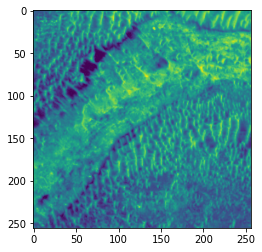

In [ ]:
oneImage = dataset[40]
plt.imshow(oneImage[0][0])
print(oneImage[0].shape)

In [ ]:
testDataset = segDataset('./TestingData/TestingPatches', training = False)
print(testDataset.IMG_NAMES)

len(testDataset)

['./TestingData/TestingPatches/images/ESP_016631_1770_RED.browse_0_0.jpg', './TestingData/TestingPatches/images/ESP_016631_1770_RED.browse_0_1.jpg', './TestingData/TestingPatches/images/ESP_016631_1770_RED.browse_0_2.jpg', './TestingData/TestingPatches/images/ESP_016631_1770_RED.browse_0_3.jpg', './TestingData/TestingPatches/images/ESP_016631_1770_RED.browse_0_4.jpg', './TestingData/TestingPatches/images/ESP_016631_1770_RED.browse_0_5.jpg', './TestingData/TestingPatches/images/ESP_016631_1770_RED.browse_0_6.jpg', './TestingData/TestingPatches/images/ESP_016631_1770_RED.browse_10_0.jpg', './TestingData/TestingPatches/images/ESP_016631_1770_RED.browse_10_1.jpg', './TestingData/TestingPatches/images/ESP_016631_1770_RED.browse_10_2.jpg', './TestingData/TestingPatches/images/ESP_016631_1770_RED.browse_10_3.jpg', './TestingData/TestingPatches/images/ESP_016631_1770_RED.browse_10_4.jpg', './TestingData/TestingPatches/images/ESP_016631_1770_RED.browse_10_5.jpg', './TestingData/TestingPatches/i

250

In [ ]:
#test_num = int(0.1 * len(dataset))
#print(f'test data : {test_num}')
# Manual seed used to recreate the random split and get the same datasets
#train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset)-test_num, test_num], generator=torch.Generator().manual_seed(181))
train_dataset = dataset
test_dataset = testDataset

In [ ]:
BACH_SIZE = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BACH_SIZE, shuffle=True, num_workers=2)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, num_workers=2)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
import torch.nn.functional as F
from torch.nn import ModuleList
import torch



class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, out_channels=32):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        bilinear = False

        self.inc = DoubleConv(n_channels, out_channels)
        self.down1 = Down(out_channels, out_channels * 2)
        self.down2 = Down(out_channels * 2, out_channels * 4)
        self.down3 = Down(out_channels * 4, out_channels * 8)
        factor = 2 if bilinear else 1
        self.down4 = Down(out_channels * 8, out_channels * 16 // factor)
        self.up1 = Up(out_channels * 16, out_channels * 8 // factor, bilinear)
        self.up2 = Up(out_channels * 8, out_channels * 4 // factor, bilinear)
        self.up3 = Up(out_channels * 4, out_channels * 2 // factor, bilinear)
        self.up4 = Up(out_channels * 2, out_channels, bilinear)
        self.outc = OutConv(out_channels, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return x1, x, logits


class MiniUNet(nn.Module):
    def __init__(self, n_channels, n_classes, out_channels=32):
        super(MiniUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        bilinear = False

        self.inc = DoubleConv(n_channels, out_channels)
        self.down1 = Down(out_channels, out_channels*2)
        self.down2 = Down(out_channels*2, out_channels*4)
        self.down3 = Down(out_channels*4, out_channels*8)
        self.up1 = Up(out_channels*8, out_channels*4, bilinear)
        self.up2 = Up(out_channels*4, out_channels*2, bilinear)
        self.up3 = Up(out_channels*2, out_channels, bilinear)
        self.outc = OutConv(out_channels, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        logits = self.outc(x)
        return x1, x, logits


class Iternet(nn.Module):
    def __init__(self, n_channels, n_classes, out_channels=32, iterations=3):
        super(Iternet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.iterations = iterations

        # define the network UNet layer
        self.model_unet = UNet(n_channels=n_channels,
                               n_classes=n_classes, out_channels=out_channels)

        # define the network MiniUNet layers
        self.model_miniunet = ModuleList(MiniUNet(
            n_channels=out_channels*2, n_classes=n_classes, out_channels=out_channels) for i in range(iterations))

    def forward(self, x):
        x1, x2, logits = self.model_unet(x)
        for i in range(self.iterations):
            x = torch.cat([x1, x2], dim=1)
            _, x2, logits = self.model_miniunet[i](x)

        return logits


In [ ]:
# # Not using -> Double Conv Class
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
# # Not using -> Double Conv Class
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
        

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        #print("out ", logits.size())
        return logits

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, n_classes=2):
        super(DiceLoss, self).__init__()
        self.classes = n_classes

    def to_one_hot(self, tensor):
        n,h,w = tensor.size()
        one_hot = torch.zeros(n,self.classes,h,w).to(tensor.device).scatter_(1,tensor.view(n,1,h,w),1)
        return one_hot

    def forward(self, inputs, target):
       
        N = inputs.size()[0]
       

        # predicted probabilities for each pixel along channel
        inputs = F.softmax(inputs,dim=1)
        
        
        # Numerator Product
        target_oneHot = self.to_one_hot(target)
         #weight_invertedChannels = 1.0
         #weight_background = 0.04

        inter = inputs * target_oneHot
        #print("inter size", inter.size())
        #(2.*intersection + smooth)/(inputs.sum() + target.sum() + smooth)
        intersection = 0
        smooth = 1

        for imageInd in range(N): 
          intersection += inter[imageInd][1].view(-1).sum() 
           #intersection += inter[imageInd][0].view(-1).sum() * weight_background

        inter = 2*intersection + smooth
        #Denominator - (inputs*target_oneHot)
        union= inputs + target_oneHot 
        ## Sum over all pixels N x C x H x W => N x C

        total2 = 0
        for imageInd in range(N):
          total2 += union[imageInd][1].view(-1).sum() 
           #total2 += union[imageInd][0].view(-1).sum() * weight_background

        union = total2 + smooth
        #union = union.view(N,self.classes,-1).sum(2)

        loss = inter/union
        ## Return average loss over classes and batch
        return 1-loss.mean()

In [ ]:

class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, n_classes=2):
        super(TverskyLoss, self).__init__()
        self.classes = n_classes

    def to_one_hot(self, tensor):
        n,h,w = tensor.size()
        one_hot = torch.zeros(n,self.classes,h,w).to(tensor.device).scatter_(1,tensor.view(n,1,h,w),1)
        return one_hot

    def forward(self, inputs, target):
       
        N = inputs.size()[0]
        alpha = 1
        beta = 1.5
        smooth=1e-6
        # predicted probabilities for each pixel along channel
        inputs = F.softmax(inputs,dim=1)
        
        
        # Numerator Product
        target_oneHot = self.to_one_hot(target)

        targets = target_oneHot
        # inputs = inputs.view(-1)
        # targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        # TP = (inputs * targets).sum()    
        # FP = ((1-targets) * inputs).sum()
        # FN = (targets * (1-inputs)).sum()
       
        # Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  

        TP = (inputs * targets)   
        FP = ((1-targets) * inputs)
        FN = (targets * (1-inputs))

        truePositives = 0
        falsePostives = 0
        falseNegatives = 0
        for imageInd in range(N): 
          truePositives += TP[imageInd][1].view(-1).sum() 
          # truePositives += TP[imageInd][0].view(-1).sum()

          falsePostives += FP[imageInd][1].view(-1).sum() 
          # falsePostives += FP[imageInd][0].view(-1).sum()

          falseNegatives += FN[imageInd][1].view(-1).sum() 
          # falseNegatives += FN[imageInd][0].view(-1).sum() 
           #intersection += inter[imageInd][0].view(-1).sum() * weight_background

        Tversky = (truePositives.mean() + smooth) / (truePositives.mean()  + alpha*falsePostives.mean()  + beta*falseNegatives.mean()  + smooth)  
        
        return 1 - Tversky

In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True, n_classes=2):
        super(DiceBCELoss, self).__init__()
        self.classes = n_classes

    def to_one_hot(self, tensor):
        n,h,w = tensor.size()
        one_hot = torch.zeros(n,self.classes,h,w).to(tensor.device).scatter_(1,tensor.view(n,1,h,w),1)
        return one_hot

    def forward(self, inputs, target):
       
        N = inputs.size()[0]
       

        # predicted probabilities for each pixel along channel
        inputs = F.softmax(inputs,dim=1)
        
        
        # Numerator Product
        target_oneHot = self.to_one_hot(target)
        smooth = 1

        weight_invertedChannels = 3
        weight_background = 1

        inter = inputs * target_oneHot
        #print("inter size", inter.size())
        #(2.*intersection + smooth)/(inputs.sum() + target.sum() + smooth)
        intersection_channels = 0
        intersection_background = 0
        # smooth = 1

        for imageInd in range(N): 
          intersection_channels += inter[imageInd][1].view(-1).sum() 
          intersection_background += inter[imageInd][0].view(-1).sum() 

        # inter = intersection 
        #print("inter ", inter)
        #Denominator 
        union= inputs + target_oneHot
        ## Sum over all pixels N x C x H x W => N x C
        union_channels=0
        union_background = 0
        total2 = 0
        for imageInd in range(N):
          union_channels += union[imageInd][1].view(-1).sum() 
          union_background += union[imageInd][0].view(-1).sum() 

        # union = total2
        #print("union ", union)
        #union = union.view(N,self.classes,-1).sum(2)
        dice_channels =intersection_channels/union_channels
        dice_channels = dice_channels.mean()*0.8

        dice_background =intersection_background/union_background
        dice_background = dice_background.mean()*0.2

        weighted_dice = (dice_channels+ dice_background)
        
        inputs = inputs.view(-1)
        targets = target_oneHot.view(-1)
        # intersection = (inputs * targets).sum()  
        # dice = ((2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth))                     
        dice_loss = 1 -  weighted_dice
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean').mean()  
        Dice_BCE = (0.3*BCE + 0.7*dice_loss)

        ## Return average loss over classes and batch
        return Dice_BCE

In [ ]:
# Updated
class WeightedDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, n_classes=2):
        super(WeightedDiceLoss, self).__init__()
        self.classes = n_classes

    def to_one_hot(self, tensor):
        n,h,w = tensor.size()
        one_hot = torch.zeros(n,self.classes,h,w).to(tensor.device).scatter_(1,tensor.view(n,1,h,w),1)
        return one_hot

    def forward(self, inputs, target):
       
        N = inputs.size()[0]
       

        # predicted probabilities for each pixel along channel
        inputs = F.softmax(inputs,dim=1)
        
        
        # Numerator Product
        target_oneHot = self.to_one_hot(target)
        weight_invertedChannels = 3
        weight_background = 1

        inter = 2*inputs * target_oneHot
        #print("inter size", inter.size())
        #(2.*intersection + smooth)/(inputs.sum() + target.sum() + smooth)
        intersection_channels = 0
        intersection_background = 0
        # smooth = 1

        for imageInd in range(N): 
          intersection_channels += inter[imageInd][1].view(-1).sum() 
          intersection_background += inter[imageInd][0].view(-1).sum() 

        # inter = intersection 
        #print("inter ", inter)
        #Denominator 
        union= inputs + target_oneHot
        ## Sum over all pixels N x C x H x W => N x C
        union_channels=0
        union_background = 0
        total2 = 0
        for imageInd in range(N):
          union_channels += union[imageInd][1].view(-1).sum() 
          union_background += union[imageInd][0].view(-1).sum() 

        # union = total2
        #print("union ", union)
        #union = union.view(N,self.classes,-1).sum(2)
        dice_channels =intersection_channels/union_channels
        dice_channels = dice_channels.mean()*0.75

        dice_background =intersection_background/union_background
        dice_background = dice_background.mean()*0.25

        weighted_dice = (dice_channels+ dice_background)

        loss = 1 - weighted_dice
        #print("loss ", loss)
        #print("loss mean ", loss.mean())
        ## Return average loss over classes and batch
        # return 1-loss.mean()
        return loss

In [ ]:
# Updated
class ComboLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, n_classes=2):
        super(ComboLoss, self).__init__()
        self.classes = n_classes

    def to_one_hot(self, tensor):
        n,h,w = tensor.size()
        one_hot = torch.zeros(n,self.classes,h,w).to(tensor.device).scatter_(1,tensor.view(n,1,h,w),1)
        return one_hot

    def forward(self, inputs, target):
       
        N = inputs.size()[0]
       

        # predicted probabilities for each pixel along channel
        inputs = F.softmax(inputs,dim=1)
        
        # Numerator Product
        target_oneHot = self.to_one_hot(target)
        
        smooth = 1

        ALPHA = 0.7 # < 0.5 penalises FP more, > 0.5 penalises FN more
        CE_RATIO = 0.3 #weighted contribution of modified CE loss compared to Dice loss

        intersection = (inputs * target_oneHot).sum()    
        inter = inputs * target_oneHot
        #print("inter size", inter.size())
        #(2.*intersection + smooth)/(inputs.sum() + target.sum() + smooth)
        intersection_channels = 0
        intersection_background = 0
        # smooth = 1

        for imageInd in range(N): 
          intersection_channels += inter[imageInd][1].view(-1).sum() 
          intersection_background += inter[imageInd][0].view(-1).sum() 

        # inter = intersection 
        #print("inter ", inter)
        #Denominator 
        union= inputs + target_oneHot
        eps=1e-9
        ## Sum over all pixels N x C x H x W => N x C
        union_channels=0
        union_background = 0
        total2 = 0
        for imageInd in range(N):
          union_channels += union[imageInd][1].view(-1).sum() 
          union_background += union[imageInd][0].view(-1).sum() 

        # union = total2
        #print("union ", union)
        #union = union.view(N,self.classes,-1).sum(2)
        dice_channels =intersection_channels/union_channels
        dice_channels = dice_channels.mean()*0.8

        dice_background =intersection_background/union_background
        dice_background = dice_background.mean()*0.2

        weighted_dice = (dice_channels+ dice_background)
        inputs = inputs.view(-1)
        targets = target_oneHot.view(-1)
        inputs = torch.clamp(inputs, eps, 1.0 - eps)       
        out = - (ALPHA * ((targets * torch.log(inputs)) + ((1 - ALPHA) * (1.0 - targets) * torch.log(1.0 - inputs))))
        weighted_ce = out.mean(-1)
        combo = ((1 - CE_RATIO) * weighted_dice) - (CE_RATIO * weighted_ce) 
        return combo

In [ ]:
# criterion = DiceLoss(n_classes=2).to(device)
criterion = WeightedDiceLoss(n_classes=2).to(device)

In [ ]:
def acc(label, predicted):
  seg_acc = (y.cpu() == torch.argmax(pred_mask, axis=1).cpu()).sum() / torch.numel(y.cpu())
  return seg_acc

In [ ]:
min_loss = torch.tensor(float('inf'))
# model = UNet(n_channels=1, n_classes=2).to(device)
model = Iternet(n_channels=1, n_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

In [ ]:
modelU = UNet(n_channels=3, n_classes=2).to(device)

In [ ]:
from pprint import pprint
os.makedirs('./saved_models', exist_ok=True)

N_EPOCHS = 25
N_DATA = len(train_dataset)
N_TEST = len(test_dataset)

plot_losses = []
scheduler_counter = 0
prediction = []

for epoch in range(N_EPOCHS):
  # training
  model.train()
  loss_list = []
  acc_list = []
  for batch_i, (x, y,z) in enumerate(train_dataloader):
      # print(x.shape)
      pred_mask = model(x.to(device))

      loss = criterion(pred_mask, y.to(device))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_list.append(loss.cpu().detach().numpy())
      acc_list.append(acc(y,pred_mask).numpy())

      sys.stdout.write(
          "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f)]"
          % (
              epoch,
              N_EPOCHS,
              batch_i,
              len(train_dataloader),
              loss.cpu().detach().numpy(),
              np.mean(loss_list),
          )
      )
  scheduler_counter += 1
  # testing
  model.eval()
  val_loss_list = []
  val_acc_list = []
  for batch_i, (x, y, z) in enumerate(test_dataloader):
      with torch.no_grad():    
          pred_mask = model(x.to(device))
      val_loss = criterion(pred_mask, y.to(device))
      val_loss_list.append(val_loss.cpu().detach().numpy())
      val_acc_list.append(acc(y,pred_mask).numpy())
    
  print(' epoch {} - loss : {:.5f} - acc : {:.2f} - val loss : {:.5f} - val acc : {:.2f}'.format(epoch, 
                                                                                                 np.mean(loss_list), 
                                                                                                 np.mean(acc_list), 
                                                                                                 np.mean(val_loss_list),
                                                                                                 np.mean(val_acc_list)))
  plot_losses.append([epoch, np.mean(loss_list), np.mean(val_loss_list)])
  #  print("prediction ", prediction.size(), prediction.data[0])
  compare_loss = np.mean(val_loss_list)
  is_best = compare_loss < min_loss
  if is_best == True:
    scheduler_counter = 0
    min_loss = min(compare_loss, min_loss)
  torch.save(model.state_dict(), './saved_models/unet_epoch_{}_{:.5f}.pt'.format(epoch,np.mean(val_loss_list)))
  
  if scheduler_counter > 5:
    lr_scheduler.step()
    print(f"lowering learning rate to {optimizer.param_groups[0]['lr']}")
    scheduler_counter = 0


[Epoch 0/25] [Batch 248/249] [Loss: 0.756476 (0.736796)] epoch 0 - loss : 0.73680 - acc : 0.96 - val loss : 0.74804 - val acc : 0.96
[Epoch 1/25] [Batch 248/249] [Loss: 0.757026 (0.733337)] epoch 1 - loss : 0.73334 - acc : 0.97 - val loss : 0.75228 - val acc : 0.96
[Epoch 2/25] [Batch 248/249] [Loss: 0.766978 (0.730886)] epoch 2 - loss : 0.73089 - acc : 0.92 - val loss : 0.73914 - val acc : 0.85
[Epoch 3/25] [Batch 248/249] [Loss: 0.764522 (0.723605)] epoch 3 - loss : 0.72361 - acc : 0.86 - val loss : 0.75355 - val acc : 0.85
[Epoch 4/25] [Batch 248/249] [Loss: 0.752346 (0.735119)] epoch 4 - loss : 0.73512 - acc : 0.90 - val loss : 0.74943 - val acc : 0.96
[Epoch 5/25] [Batch 248/249] [Loss: 0.429534 (0.718512)] epoch 5 - loss : 0.71851 - acc : 0.89 - val loss : 0.73624 - val acc : 0.90
[Epoch 6/25] [Batch 248/249] [Loss: 0.775709 (0.726110)] epoch 6 - loss : 0.72611 - acc : 0.92 - val loss : 0.76305 - val acc : 0.74
[Epoch 7/25] [Batch 248/249] [Loss: 0.674092 (0.730406)] epoch 7 - lo

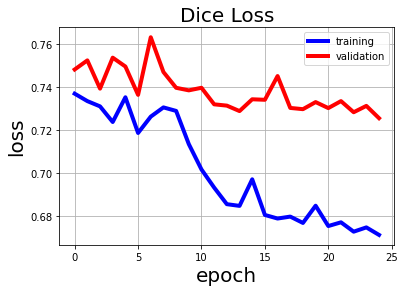

In [ ]:
# plot loss
plot_losses = np.array(plot_losses)
plt.plot(plot_losses[:,0], plot_losses[:,1], color='b', linewidth=4)
plt.plot(plot_losses[:,0], plot_losses[:,2], color='r', linewidth=4)
plt.title('Dice Loss', fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.ylabel('loss',fontsize=20)
plt.grid()
plt.legend(['training', 'validation']) # using a named size
plt.show()

In [ ]:
# model.load_state_dict(torch.load('/content/saved_models/Iternet zeor thresh aug two images good.pt'))
model.load_state_dict(torch.load('/content/saved_models/unet_epoch_24_0.72538.pt'))

<All keys matched successfully>

In [ ]:
modelU.load_state_dict(torch.load('/content/saved_models/Less Noise Patch unet_epoch_38_0.90805.pt'))

<All keys matched successfully>

In [ ]:
# model.eval()

# for batch_i, (x, y,z) in enumerate(test_dataloader):
#     for j in range(len(x)):
#         result = model(x.to(device)[j:j+1])
#         mask = torch.argmax(result, axis=1).cpu().detach().numpy()[0]
#         im = np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy()*255
#         im = im.astype(int)
#         gt_mask = y[j]

#         plt.figure(figsize=(12,12))

#         plt.subplot(1,3,1)
#         im = np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy()*255
#         im = im.astype(int)
#         plt.imshow(im)

#         plt.subplot(1,3,2)
#         plt.imshow(gt_mask)

#         plt.subplot(1,3,3)
#         plt.imshow(mask)
#         plt.show()

In [ ]:
def getImageIndex(Array, imageID):
  imageIndex = -1
  for n in range (0,len(Array)):
    if Array[n][0] == imageID:
      imageIndex = n
      break
  
  return imageIndex

In [ ]:
def getImageSize(imageList, imageID):
  imageSize =[patchSize,patchSize]
  for image in imageList:
    if image[0]==imageID:
      imageSize= image[1]
      break
  return imageSize

In [ ]:
model.eval()
predictions = []
# print(testImageSizes)
for batch_i, (x, y,z) in enumerate(test_dataloader):
    for j in range(len(x)):
      result = model(x.to(device)[j:j+1])
      mask = torch.argmax(result, axis=1).cpu().detach().numpy()[0]
      imageIndex = getImageIndex(predictions,z[j][36:62])
      # print("list ",z[j])
      imageSize = getImageSize(testImageSizes,z[j][36:62])
      cordinates = (z[j][63:-4]).split("_")
      
      im = np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy()*255
      im = im.astype(int)
      
      gt_mask = y[j]
      gt_mask = gt_mask.cpu().detach().numpy()
      if imageIndex!=-1:
        (predictions[imageIndex][1]).append([cordinates,im,gt_mask,mask])
      else:
        predictions.append([z[j][36:-8],[[cordinates,im,gt_mask,mask]],imageSize])

In [ ]:
from operator import itemgetter

def constructImageRow(rowPatches):
  sortedPatches = sorted(rowPatches, key=itemgetter(0))
  rowImge =  torch.from_numpy(sortedPatches[0][1])
  for pt in sortedPatches[1:]:
    rowImge = torch.cat(((rowImge),torch.from_numpy(pt[1])), 1)
  return rowImge
    



In [ ]:
from operator import itemgetter

def reconstructImage(ImagePatches,type):
  variable =True
  current_row = 0
  rows =[]
  imageSize = ImagePatches[2]
  # print("size ",imageSize  )
  imageWidth = imageSize[0]
  imageHeight = imageSize[1]
  predictionPatches = ImagePatches[1]
  for n in range(0,len(predictionPatches)):
    y_cor = int(predictionPatches[n][0][0])
    x_cor = int(predictionPatches[n][0][1])
    
    if (current_row==y_cor and x_cor==0):
      rowPatches = [[x_cor,predictionPatches[n][type]]]
      # rowImage = torch.from_numpy(predictionPatches[n][type])
    elif (current_row==y_cor and x_cor!=0):
      rowPatches.append([x_cor,predictionPatches[n][type]])
      # rowImage = torch.cat(((rowImage),torch.from_numpy(predictionPatches[n][type])), 1)
    else:
      # numPatchesInRow = int(predictionPatches[n-1][0][1])+1
      numPatchesInRow = len(rowPatches)+1
      newRow = constructImageRow(rowPatches)
      rows.append([current_row,newRow])
      rowPatches = [[x_cor,predictionPatches[n][type]]]
      # rowImage = torch.from_numpy(predictionPatches[n][type])
      current_row = y_cor
    if(n+1==len(predictionPatches)):
      newRow = constructImageRow(rowPatches)
      rows.append([y_cor,newRow])
      variable = False

  
  rows = sorted(rows, key=itemgetter(0))
  
  fullImage = rows[0][1]
  # print("y_cor", rows[0][0])
  # plt.imshow(rows[0][1])
  # plt.show()
  for row in rows[1:]:
    fullImage = torch.cat(((fullImage),(row[1])), 0)
  croppedImage = fullImage[0:imageHeight,0:imageWidth]

  return croppedImage

# ImageOut = reconstructImage(predictions[2])
# plt.figure(figsize=(15,15))   
# plt.imshow(ImageOut)

F1 Score =  0.9387732269043702
Jaccaard Score =  0.8846113297405237
AUC Score =  0.5929358563068599
(1, 2863, 1639)


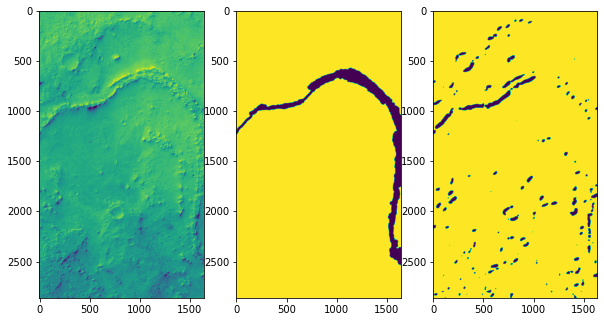

F1 Score =  0.9756115196185835
Jaccaard Score =  0.9523843134738575
AUC Score =  0.7554163380492047
(1, 2412, 1703)


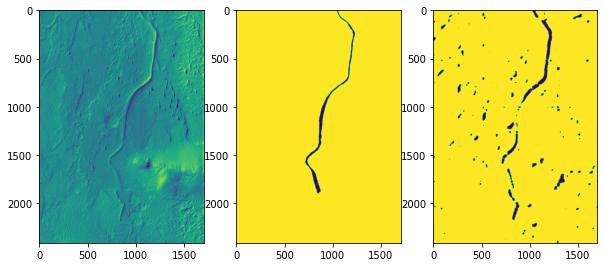

F1 Score =  0.9580608606152599
Jaccaard Score =  0.9194979096197404
AUC Score =  0.5046565514161511
(1, 3926, 1519)


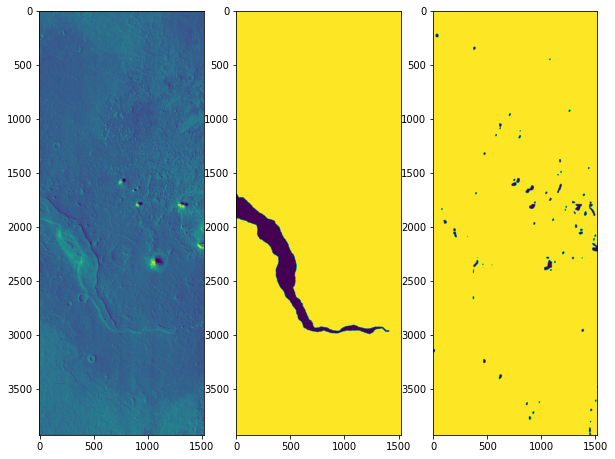

Model F1 Score =  0.9574818690460711
Model F1 Score =  0.9188311842780404
Model AUC Score =  0.6176695819240718


In [ ]:
from skimage import io, morphology
from sklearn.metrics import f1_score   
from sklearn.metrics import jaccard_score
from sklearn.metrics import roc_auc_score

noisyPredictions=[]
noisyScores =[]
f1_total = 0
jaccard_total = 0
roc_total = 0

for element in predictions:

  image = reconstructImage(element,1)
  annotatedMask = reconstructImage(element,2)
  predictionMask = reconstructImage(element,3)
  noisyPredictions.append(predictionMask)

  annotated= annotatedMask.cpu().detach().numpy()
  annotated[annotated<0.5] = 255
  annotated[annotated==1] = 0
  numpyPred = predictionMask.cpu().detach().numpy()
  numpyPred[numpyPred<0.5] = 255
  numpyPred[numpyPred==1] = 0

  copy_annotated = np.copy(annotatedMask)
  copy_annotated = copy_annotated.flatten()
  copy_prediction = np.copy(predictionMask)
  copy_prediction = copy_prediction.flatten()

  f1_scored = f1_score(copy_annotated,copy_prediction, average='micro',zero_division=1)
  jaccard = jaccard_score(copy_annotated,copy_prediction,average='micro',zero_division=1)

  
  
  roc = roc_auc_score(copy_annotated,copy_prediction,average='micro')
  roc_total += roc
  f1_total += f1_scored
  jaccard_total +=jaccard

  print("F1 Score = ",f1_scored)
  print("Jaccaard Score = ",jaccard)
  print("AUC Score = ",roc)
  # noisyScores.append([f1_scored,jaccard,roc])
  image = image.cpu().detach().numpy()
  image = np.moveaxis(image, -1, 0)
  print(image.shape)
  plt.figure(figsize=(10,10))
  plt.subplot(1,3,1)
  plt.imshow(image[0])
  
  plt.subplot(1,3,2)
  plt.imshow(annotatedMask)
  
  
  
  plt.subplot(1,3,3)
  plt.imshow(numpyPred)
  
  # numpyPred = numpyPred.astype('uint8')
  # ret, thresh = cv2.threshold(numpyPred, 127, 255, 0)
  # # contours,hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  # contours,hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  # cnt = contours[0]
  
  # if len(contours) != 0:
  #   for i in range(len(contours)):
  #     # print(len(contours[i]))
  #     if len(contours[i]) >= 120:
  #       cv2.drawContours(thresh,contours,-1,(150,10,255),3)
  #       ellipse=cv2.fitEllipse(contours[i])
  # for i in range(len(contours)):
  #   if len(contours[i]) >= 50:
  #     # Lines
  #     # rows,cols = thresh.shape[:2]
  #     # rows = cols = 200
  #     # [vx,vy,x,y] = cv2.fitLine(contours[i], cv2.DIST_L2,0,0.01,0.01)
  #     # lefty = int((-x*vy/vx) + y)
  #     # righty = int(((cols-x)*vy/vx)+y)
  #     # cv2.line(thresh,(cols-1,righty),(0,lefty),(0,255,0),2)
  #     #

  #     # ellipses
  #     # ellipse = cv2.fitEllipseDirect(contours[i])
  #     # print(ellipse)
  #     # cv2.ellipse(thresh,ellipse,(0,255,0),2)

  #     # circles
  #     # (x,y),radius = cv2.minEnclosingCircle(contours[i])
  #     # center = (int(x),int(y))
  #     # radius = int(radius)
  #     # cv2.circle(thresh,center,radius,(0,255,0),2)

  #     # rectangles
  #     rect = cv2.minAreaRect(contours[i])
  #     box = cv2.boxPoints(rect)
  #     box = np.int0(box)
  #     cv2.drawContours(thresh,[box],0,(0,0,255),2)
  # # kernel = np.ones((15,15),np.uint8)
  # # numpyPred = numpyPred.astype('uint8')
  # numpyPred = numpyPred.astype(dtype=bool)
  # kernel1 = np.ones((10,10),np.uint8)
  # kernel2 =cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (40, 40))
  # array_img = np.array(numpyPred)
  # print(erosion)
  # closing = cv2.morphologyEx(numpyPred, cv2.MORPH_CLOSE, kernel1)
  # opening = cv2.morphologyEx(dilation, cv2.MORPH_OPEN, kernel2)
  # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 20))
  # opened_mask = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)
  
  # closee = morphology.remove_small_objects(numpyPred, 400, connectivity=1)
  # kernel1 =cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
  # newPred = closee.astype('uint8')
  # dilation = cv2.dilate(newPred,kernel1,iterations = 2)
  # # closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
  # plt.subplot(1,4,4)
  # # plt.imshow(dilation, cmap='gray')
  
  # plt.imshow(thresh)
  plt.show()

print("Model F1 Score = ",f1_total/3)
print("Model F1 Score = ",jaccard_total/3)
print("Model AUC Score = ",roc_total/3)
noisyScores.append([f1_total/3,jaccard_total/3,roc_total/3])

In [ ]:
modelU.eval()
predictionsU = []
# print(testImageSizes)
for batch_i, (x, y,z) in enumerate(test_dataloader):
    for j in range(len(x)):
      result = modelU(x.to(device)[j:j+1])
      mask = torch.argmax(result, axis=1).cpu().detach().numpy()[0]
      imageIndex = getImageIndex(predictionsU,z[j][36:62])
      # print("list ",z[j])
      imageSize = getImageSize(testImageSizes,z[j][36:62])
      cordinates = (z[j][63:-4]).split("_")
      
      im = np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy()*255
      im = im.astype(int)
      
      gt_mask = y[j]
      gt_mask = gt_mask.cpu().detach().numpy()
      if imageIndex!=-1:
        (predictionsU[imageIndex][1]).append([cordinates,im,gt_mask,mask])
      else:
        predictionsU.append([z[j][36:-8],[[cordinates,im,gt_mask,mask]],imageSize])

F1 Score =  0.9505958179265148
Jaccaard Score =  0.9058433672793852
AUC Score =  0.5635893644630023


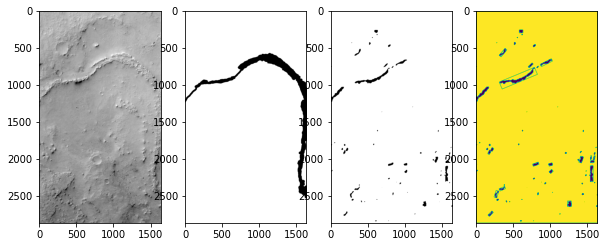

F1 Score =  0.9829101215394938
Jaccaard Score =  0.9663945560320117
AUC Score =  0.6925103175436724


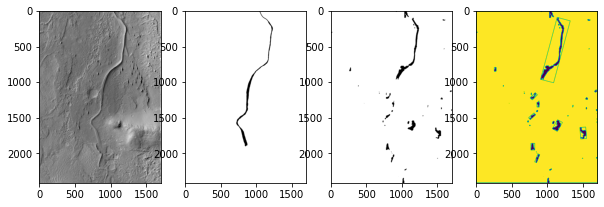

F1 Score =  0.9616623801016634
Jaccaard Score =  0.9261557721426098
AUC Score =  0.5417643332386664


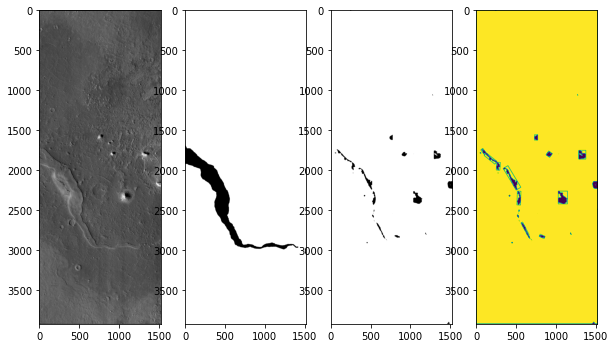

Model F1 Score =  0.9650561065225572
Model F1 Score =  0.9327978984846689
Model AUC Score =  0.5992880050817804


In [ ]:
from skimage import io, morphology
from sklearn.metrics import f1_score   
from sklearn.metrics import jaccard_score
from sklearn.metrics import roc_auc_score

noiseLessPredictions = []
noiseLessScores= []

annotations = []
images = []
f1_total = 0
jaccard_total = 0
roc_total = 0

for element in predictionsU:

  image = reconstructImage(element,1)
  annotatedMask = reconstructImage(element,2)
  predictionMask = reconstructImage(element,3)
  noiseLessPredictions.append(predictionMask)
  annotations.append(annotatedMask)
  images.append(image)

  annotated= annotatedMask.cpu().detach().numpy()
  annotated[annotated<0.5] = 255
  annotated[annotated==1] = 0
  numpyPred = predictionMask.cpu().detach().numpy()
  numpyPred[numpyPred<0.5] = 255
  numpyPred[numpyPred==1] = 0

  copy_annotated = np.copy(annotatedMask)
  copy_annotated = copy_annotated.flatten()
  copy_prediction = np.copy(predictionMask)
  copy_prediction = copy_prediction.flatten()
  
  f1_scored = f1_score(copy_annotated,copy_prediction, average='micro',zero_division=1)
  jaccard = jaccard_score(copy_annotated,copy_prediction,average='micro',zero_division=1)
  roc = roc_auc_score(copy_annotated,copy_prediction,average='micro')

  roc_total += roc
  f1_total += f1_scored
  jaccard_total +=jaccard

  print("F1 Score = ",f1_scored)
  print("Jaccaard Score = ",jaccard)
  print("AUC Score = ",roc)
  # noiseLessScores.append([f1_scored,jaccard,roc])
  plt.figure(figsize=(10,14))
  plt.subplot(1,4,1)
  plt.imshow(image)
  
  plt.subplot(1,4,2)
  plt.imshow(annotatedMask ,cmap = 'gray')
  
  
  
  plt.subplot(1,4,3)
  plt.imshow(numpyPred, cmap = 'gray')
  
  numpyPred = numpyPred.astype('uint8')
  ret, thresh = cv2.threshold(numpyPred, 127, 255, 0)
  # contours,hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  contours,hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  cnt = contours[0]
  # if len(contours) != 0:
  #   for i in range(len(contours)):
  #     # print(len(contours[i]))
  #     if len(contours[i]) >= 120:
  #       cv2.drawContours(thresh,contours,-1,(150,10,255),3)
  #       ellipse=cv2.fitEllipse(contours[i])
  for i in range(len(contours)):
    if len(contours[i]) >= 50:
      # Lines
      # rows,cols = thresh.shape[:2]
      # rows = cols = 200
      # [vx,vy,x,y] = cv2.fitLine(contours[i], cv2.DIST_L2,0,0.01,0.01)
      # lefty = int((-x*vy/vx) + y)
      # righty = int(((cols-x)*vy/vx)+y)
      # cv2.line(thresh,(cols-1,righty),(0,lefty),(0,255,0),2)
      #

      # ellipses
      # ellipse = cv2.fitEllipseDirect(contours[i])
      # print(ellipse)
      # cv2.ellipse(thresh,ellipse,(0,255,0),2)

      # circles
      # (x,y),radius = cv2.minEnclosingCircle(contours[i])
      # center = (int(x),int(y))
      # radius = int(radius)
      # cv2.circle(thresh,center,radius,(0,255,0),2)

      # rectangles
      rect = cv2.minAreaRect(contours[i])
      box = cv2.boxPoints(rect)
      box = np.int0(box)
      cv2.drawContours(thresh,[box],0,(0,0,255),2)
  # kernel = np.ones((15,15),np.uint8)
  # numpyPred = numpyPred.astype('uint8')
  numpyPred = numpyPred.astype(dtype=bool)
  # kernel1 = np.ones((10,10),np.uint8)
  # kernel2 =cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (40, 40))
  # array_img = np.array(numpyPred)
  # print(erosion)
  # closing = cv2.morphologyEx(numpyPred, cv2.MORPH_CLOSE, kernel1)
  # opening = cv2.morphologyEx(dilation, cv2.MORPH_OPEN, kernel2)
  # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 20))
  # opened_mask = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)
  
  closee = morphology.remove_small_objects(numpyPred, 400, connectivity=1)
  kernel1 =cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
  newPred = closee.astype('uint8')
  dilation = cv2.dilate(newPred,kernel1,iterations = 2)
  # closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
  plt.subplot(1,4,4)
  # plt.imshow(dilation, cmap='gray')
  
  plt.imshow(thresh)
  plt.show()
print("Model F1 Score = ",f1_total/3)
print("Model F1 Score = ",jaccard_total/3)
print("Model AUC Score = ",roc_total/3)
noiseLessScores.append([f1_total/3,jaccard_total/3,roc_total/3]) 

In [ ]:
#  Filtering
width, height = noisyPredictions[0].shape
print(noisyPredictions[0].shape)
print(width, height)

torch.Size([2863, 1639])
2863 1639


In [ ]:
import torchvision.transforms as transforms
import torchvision
import PIL

# imageNames = sorted(glob('./Martian Inverted Channels' + '/*/images/*.jpg'))
filteredPredictions = []

patchHeight = 64
patchWidth = 64
filterSize = 64
patchList = []

for num in range(0,len(noisyPredictions)):
  # image = cv2.imread(testImagePath)
  
  # mask_path = testImagePath.replace('images', 'masks').replace('.jpg', '.png')
  # mask = cv2.imread(mask_path)
  noisyImage = np.copy(noisyPredictions[num])/255
  # print(np.count_nonzero(noisyImage==0),noisyImage)
  noiseLessImage = np.copy(noiseLessPredictions[num]/255)
  # print(np.count_nonzero(noisyImage))

  imageHeight, imageWidth = noisyPredictions[num].shape
  # testImageSizes.append([testImagePath[len(testImagePath)-30:-4],[imageWidth,imageHeight]])

  for y in range (0,imageHeight,filterSize):
    for x in range (0,imageWidth,filterSize):
      
      # Bottom - Right side corner of the image
      if ((y+patchHeight+filterSize > imageHeight) and (x+patchWidth+filterSize > imageWidth)):
        filter = noiseLessImage [y -filterSize :imageHeight,x - filterSize:imageWidth]
        num_of_zeros = np.count_nonzero(filter==0)
        # print(num_of_zeros,noisyImage [y:imageHeight,x:imageWidth])
        if(num_of_zeros<=0):
          noisyImage [y:imageHeight,x:imageWidth]=1

      # Top and Middle - Right side of the Image
      elif ((y+patchHeight+filterSize <= imageHeight) and (x+patchWidth+filterSize > imageWidth)):
        if(y-filterSize>=0):
          filter = noiseLessImage[y-filterSize:y+patchHeight+filterSize,x-filterSize:imageWidth]
        else:
          filter = noiseLessImage[0:y+patchHeight+filterSize,x-filterSize:imageWidth]
        num_of_zeros = np.count_nonzero(filter==0)
        if(num_of_zeros<=5):
          noisyImage [y:y+patchHeight,x:imageWidth]=1

      # Bottom - Left and Middle parts of the Image
      elif ((y+patchHeight+filterSize > imageHeight) and (x+patchWidth+filterSize <= imageWidth)):
        if(x-filterSize>=0):
          filter = noiseLessImage[y-filterSize:imageHeight,x-filterSize:x+patchWidth+filterSize]
        else:
          filter = noiseLessImage[y-filterSize:imageHeight,0:x+patchWidth+filterSize]
        num_of_zeros = np.count_nonzero(filter==0)
        if(num_of_zeros<=5):
          noisyImage [y:imageHeight,x:x+patchWidth]=1


      else:
        # (y+patchHeight+filterSize<=imageHeight) and (x+patchWidth+filterSize<=imageWidth))
        if((x-filterSize>=0) and (y-filterSize>=0)):
          filter = noiseLessImage[y-filterSize:y+patchHeight+filterSize,x-filterSize:x+patchWidth+filterSize]
        elif((x-filterSize>=0) and (y-filterSize<0)):
          filter = noiseLessImage[0:y+patchHeight+filterSize,x-filterSize:x+patchWidth+filterSize]
        elif((x-filterSize<0) and (y-filterSize<0)):
          filter = noiseLessImage[y-filterSize:y+patchHeight+filterSize,0:x+patchWidth+filterSize]
        else:
          filter = noiseLessImage[0:y+patchHeight+filterSize,0:x+patchWidth+filterSize]
        num_of_zeros = np.count_nonzero(filter==0)
        if(num_of_zeros<=5):
          noisyImage [y:y+patchHeight,x:x+patchWidth]=1
  filteredPredictions.append(noisyImage)









Median F1 Score =  0.9339076218615219
Median Jaccaard Score =  0.9041255307770159
Median ROC score =  0.5635598190870372


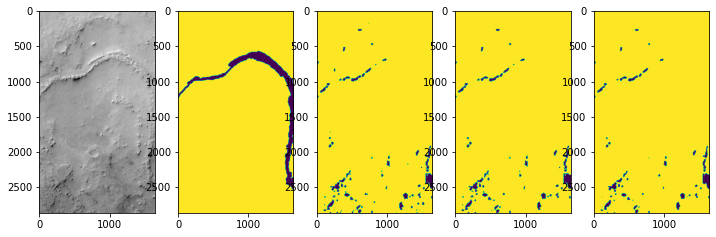

Median F1 Score =  0.9726626610461396
Median Jaccaard Score =  0.9529578407092867
Median ROC score =  0.7360066200163341


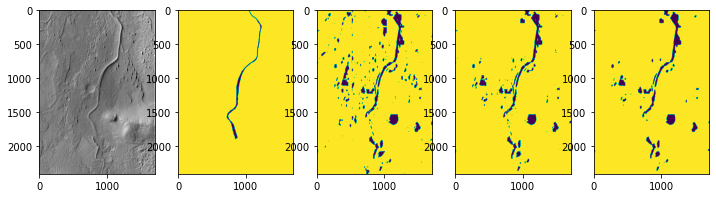

Median F1 Score =  0.9459497158097213
Median Jaccaard Score =  0.9181129270811367
Median ROC score =  0.5873713866670196


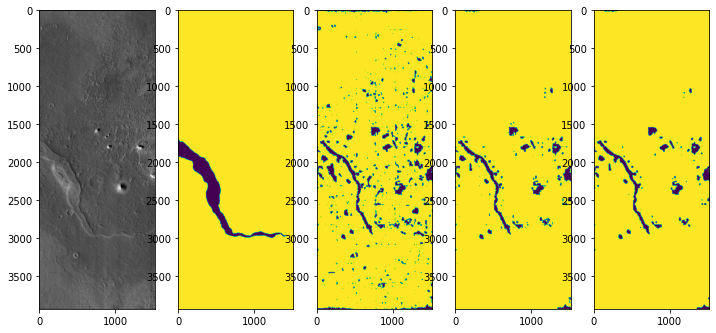


******************************************
Model F1 Score =  0.9498323333512794
Model Jaccard  Score =  0.9045291956542735
Model AUC  Score =  0.6332884410952494

******************************************


In [ ]:
f1_sum = 0
jaccard_sum = 0
roc_sum = 0
median_f1_sum = 0
median_jaccard_sum = 0
median_roc_sum = 0

filteredScores = []
medianScores =[]
image_boxes = []
medianFilterPredictions =[]

for n in range(0,len(filteredPredictions)):
  boxes=[]
 

  copy_annotated= np.copy(annotations[n])
  
  # annotated[annotated<=123] = 1
  # annotated[annotated>123] = 0
  
  copy_prediction = np.copy(filteredPredictions[n])
  copy_prediction[copy_prediction>=0.5] = 255
  copy_prediction[copy_prediction<0.5] = 0
  

  copy_annotated = copy_annotated.flatten()
  copy_prediction = copy_prediction.flatten()
  
  # print(copy_annotated[:30])
  # print(copy_prediction[:30])
  f1Score= f1_score(copy_annotated,copy_prediction, average='micro',zero_division=1)
  jaccardScore = jaccard_score(copy_annotated,copy_prediction,average='micro',zero_division=1)
  # print("F1 Score = ",f1Score)
  # print("Jaccaard Score = ",jaccardScore)
  roc = roc_auc_score(copy_annotated,copy_prediction,average='micro')

  # filteredScores.append([f1Score,jaccardScore,roc])
  # print("AUC Score = ",roc)

  f1_sum += f1Score
  jaccard_sum += jaccardScore
  roc_sum +=roc
  
  # print("F1 Score = ",f1_scored)
  # print("Jaccaard Score = ",jaccard)
  # numpyPred = np.copy(filteredPredictions[n])
  

  result = ndimage.median_filter(filteredPredictions[n], size=20)
  # result_c = np.copy(result)
  result_c = np.copy(result)
  medianFilterPredictions.append(result_c)
  result[result>=0.5] = 255
  result[result<0.5] = 0
  median_result = np.copy(result)
  
  median_result=np.pad(median_result, ((1, 1), (1, 1)), 'constant', constant_values=(255, 255))
  
  
  img_height, img_width = median_result.shape
  # numpyPred[numpyPred<0.5] = 
  # numpyPred[numpyPred==1] = 
  median_result = median_result.astype('uint8')
  ret, thresh = cv2.threshold(median_result, 0.5, 1, 0)
  # contours,hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  contours,hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
  for i in range(len(contours)):
    if len(contours[i]) >= 1:
      # rectangles
      rect = cv2.minAreaRect(contours[i])
      boxOriginal = cv2.boxPoints(rect)
      boxOriginal = np.int0(boxOriginal)
      (center, (w,h), angle) = rect # take it apart
      if w < h:
        distance = h
      else:   
        distance=w

      rectNew = (center, (w,h), angle)
      box = cv2.boxPoints(rectNew)
      box = np.int0(box)
      boxes.append([box,distance,contours[i],rect])
  
  image_boxes.append(boxes)
  plt.figure(figsize=(12,12))
  plt.subplot(1,5,1)
  plt.imshow(images[n])


  plt.subplot(1,5,2)
  plt.imshow(annotations[n])


  plt.subplot(1,5,3)
  # plt.imshow(filteredPredictions[n])
  plt.imshow(noisyPredictions[n])


  plt.subplot(1,5,4)
  plt.imshow(filteredPredictions[n])

  
  r_copy = np.copy(result)
  
  result = result.flatten()
  
  resultf1Score = f1_score(copy_annotated,result, average='weighted',zero_division=1)
  resultjaccardScore = jaccard_score(copy_annotated,result,average='weighted',zero_division=1)
  print("Median F1 Score = ",resultf1Score)
  print("Median Jaccaard Score = ",resultjaccardScore)
  resultroc = roc_auc_score(copy_annotated,result,average='weighted')
  print("Median ROC score = ",resultroc)
  # medianScores.append([resultf1Score,resultjaccardScore,resultroc])

  median_f1_sum += resultf1Score
  median_jaccard_sum += resultjaccardScore
  median_roc_sum +=resultroc
  # print("Median AUC Score = ",resultroc)


  plt.subplot(1,5,5)
  plt.imshow(r_copy)
  # plt.imshow(thresh)
  plt.show()
  
print()
print("******************************************")
print("Model F1 Score = ",f1_sum/3)
print("Model Jaccard  Score = ",jaccard_sum/3)
print("Model AUC  Score = ",roc_sum/3)
print()
print("******************************************")

filteredScores.append([f1_sum/3,jaccard_sum/3,roc_sum/3])
medianScores.append([median_f1_sum/3,median_jaccard_sum/3,median_roc_sum/3])


# print(len(filteredPredictions),len(noisyPredictions))

In [ ]:
# medianFilterPredictions =[]
# copy_filteredPredictions = np.copy(filteredPredictions)
# for predict in copy_filteredPredictions:
#   result = ndimage.median_filter(predict, size=20)
#   result[result>=0.5] = 255
#   result[result<0.5] = 0
#   r_copy = np.copy(result)
#   medianFilterPredictions.append(r_copy)
#   # plt.imshow(r_copy)
#   # plt.show()



In [ ]:
import math
criteria = ["F1 Score", "Jaccard Score", "AUC Score"]


print("********************---------------------------- Model Evaluation ----------------------------********************")
print()
print ("{:<17} {:<22} {:<22} {:<22} {:<22}".format('Criteria', 'Noisy Model', 'Noise Less Model', 'Filtered Model', 'Filtered+Median Filter Model'))
print()
for a in range(0,len(filteredScores[0])):
  print ("{:<17} {:<22} {:<22} {:<22} {:<22}".format(criteria[a], round(float(noisyScores[0][a]),5), round(float(noiseLessScores[0][a]),5), round(float(filteredScores[0][a]),5), round(float(medianScores[0][a]),5)))

********************---------------------------- Model Evaluation ----------------------------********************

Criteria          Noisy Model            Noise Less Model       Filtered Model         Filtered+Median Filter Model

F1 Score          0.93343                0.96506                0.94983                0.95084               
Jaccard Score     0.87545                0.9328                 0.90453                0.92507               
AUC Score         0.62825                0.59929                0.63329                0.62898               


In [ ]:
image_boxes_copies =[]
for bx in image_boxes:
  box = np.copy(bx)
  image_boxes_copies.append(box)


/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:804: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)


In [ ]:
for img in range(0,len(image_boxes_copies)):
  imageE = sorted(image_boxes_copies[img],reverse=True,key=lambda x: x[1])
  whole_c = imageE.pop(0)
  (center_l, (w_l,h_l), angle_l) = imageE[0][3]
  distance_l = imageE[0][1]
  for boxIndex in range(0,len(imageE)):
    (center, (w,h), angle) = imageE[boxIndex][3]
    factor = h/w
    if w < h:
      if(h*h/w>2*distance_l):
        h=2*distance_l
      else:
        h=h*h/w
    else:
      if(w*w/h>2*distance_l):
        w=2*distance_l
      else:
        w=w*w/h

    rectNew1 = (center, (w,h), angle)
    box = cv2.boxPoints(rectNew1)
    box = np.int0(box)
    imageE[boxIndex][0] = box
  image_boxes_copies[img] = imageE





In [ ]:
from shapely.geometry import Polygon

def does_overlap(rect1, rec2):
  polygon_1 = Polygon(rect1)
  polygon_2 = Polygon(rec2)
  
  intersect = polygon_1.intersection(
      polygon_2).area / polygon_1.union(polygon_2).area
  
  # Print the intersection percentage
  intersection = round(intersect*100, 2)
  if(intersection >0):
    return True
  else:
    return False


In [ ]:
copy_i_boxes = np.copy(image_boxes_copies)
not_accepted_contours = []
for image in copy_i_boxes:
  n_accepted = []
  imageE = sorted(image,reverse=True,key=lambda x: x[1])
  # print(imageE[0:7])
  # break
  # whole_c = imageE.pop(0)
  print("--------------------------------------------------")
  print("whole contours: ",len(imageE))
  largest_c = imageE.pop(0)
  accepted_contours = [largest_c]
  c_detected =True
  while(c_detected):
    c_detected =False
    for a_element in accepted_contours:
      temp_accepted_indexes = []
      for r_element in range(0,len(imageE)):
        overlap = does_overlap(a_element[0],imageE[r_element][0])
        if(overlap ==True):
          c_detected =True
          temp_accepted_indexes.append(r_element)
      
      sorted_indexes = sorted(temp_accepted_indexes,reverse=True)
      for s_index in sorted_indexes:
        element = imageE.pop(s_index)
        accepted_contours.append(element)
  
  print("accepted contours: ",len(accepted_contours))
  print("not accepted contours: ",len(imageE))
  not_accepted_contours.append(imageE)

  





--------------------------------------------------
whole contours:  56
accepted contours:  5
not accepted contours:  51
--------------------------------------------------
whole contours:  47
accepted contours:  15
not accepted contours:  32
--------------------------------------------------
whole contours:  66


/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


accepted contours:  12
not accepted contours:  54
